# Add Random Noise to Simulated Data

## Import pkg, Set the Run-Directory and set File-format for Saving Plots:

In [1]:
import h5py 
import numpy as np
from numpy.fft import fftn, fftshift # no need to use numpy.fft.fftn/fftshift
import matplotlib.cm as cm
import matplotlib.pyplot as pypl
import os, time
#this_dir = os.path.dirname(os.path.realpath(__file__))
this_dir = os.path.dirname(os.path.realpath('CCA_cxi_84-X_v3.py'))
frmt = 'eps'

### Use Boolean Expression to Chooose which Parts to Run:

In [2]:
# ---- Choose What to Run: ----
random_noise_1quad =True			## Generate random Noise in one quardant ##

plot_diffraction = False		## if False : No plot of Diffractin Patterns ##
XCCA_Loki = True 				## if True: run XCCA with Loki-pkg ##
XCCA_cxiLT14py = True	## if True: run XCCA with A.Martins Scripts ##

add_noise = True						## Add Generated Noise to Correlations ##

## Set which Sumulation to use e.g. for 'noisefree_Beam-NarrInt_84-119_4M0_ed_(none-sprd0)_#5.cxi' (GDrive/experiments/LCLS/CXI-2018_Martin/simulations):

In [3]:
name ='noisefree_Beam-NarrInt'
run = '84-119'
pdb = '4M0_ed'
noisy = 'none'
n_spread= 0
N= 5

rmin, rmax = 300, 500

### Make a Storing Directory for Plots:

In [4]:
# ---- Make an Output Dir: ----
if N is None:	outdir = this_dir +'/%s_%s_%s_(%s-sprd%s)/' %(name,run,pdb,noisy,n_spread)
else:	outdir = this_dir+'/%s_%s_%s_(%s-sprd%s)_#%i/' %(name,run,pdb,noisy,n_spread,N)
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir_raw =outdir ## For storting raw imgs if plot_diffraction=TRUE ##
if random_noise_1quad:
    outdir = this_dir+ '/random_noise_1quad_(%s_%s_%s)/' %(pdb,noisy,n_spread)
    if not os.path.exists(outdir):
        os.makedirs(outdir)

## Load the Diffraction Patterns:

In [5]:
# ----	Read in Data from CXI-file: ----
if N is None:	data_file =this_dir+'/%s_%s_%s_(%s-sprd%s).cxi'%(name,run,pdb,noisy,n_spread)
else:	data_file =this_dir +'/%s_%s_%s_(%s-sprd%s)_#%i.cxi'%(name,run,pdb,noisy,n_spread,N)

with h5py.File(data_file, 'r') as f:
    intensity_pattern = np.asarray(f["entry_1/data_1/data"])
    photon_e_eV = np.asarray(f["source/incident_energy"] )			# [eV]
    photon_e_eV = int(photon_e_eV[0]) 								# typecast 'Dataset' to int

    photon_wavelength = np.asarray(f["source/incident_wavelength"]) #[m]
    photon_wavelength= float(photon_wavelength[0])					# typecast 'Dataset' to float
    wl_A = photon_wavelength*1E+10 									#[A]

    psa = np.asarray(f["detector/pixel_size_um"])  					#[um]
    ps = int(psa[0]) 												# typecast 'Dataset' to int

    dtc_dist_arr = np.asarray(f["detector/detector_dist_m"])		#[m]
    dtc_dist = float(dtc_dist_arr[0]) 								# typecast 'Dataset' to float

## Load the 'Better Mask Assembled':

In [6]:
#	--- Mask from assembly (only 0.0 an 1.0 in data): ---
mask_better = np.load("%s/../masks/better_mask-assembled.npy" %str(this_dir))
## if data is not NOT binary:  ione =np.where(mask_better < 1.0), mask_better[ione] = 0.0 # Make sure that all data < 1.0 is 0.0 	##  
mask_better = mask_better.astype(int) 	## Convert float to integer ##
print"Dim of the assembled mask: ", mask_better.shape

Ip_w_mb=np.multiply(intensity_pattern,mask_better)	# Intensity Pattern with Mask

Dim of the assembled mask:  (1738, 1742)


## Set the Center from the loaded Mask:

In [7]:
# ---- Centre Coordiates : ----
cntr_msk =np.asarray([(mask_better.shape[1]-1)/2.0, (mask_better.shape[0]-1)/2.0 ]) ## (X,Y)
print "\n Centre from Mask: ", cntr_msk ##[870, 868]; [869.5, 871.5]; [871.5, 869.5]
cntr= cntr_msk 	## (X,Y) if use center point from the Msak ##
cntr_int=np.around(cntr).astype(int)  ## (rounds to nearest int) for the center coordinates in pixles as integers ##
print "\n Centre as Integer: ", cntr_int,  "\n"


 Centre from Mask:  [870.5 868.5]

 Centre as Integer:  [870 868] 



## Try 3 Different Ways to add Noise to the 2nd quadrant:

In [8]:
ip = intensity_pattern
nlevel = 0.2	## highest level of noise in percent of Maximum signal ##

# ---- Noise Matrices (Y, X) : ---- #
rand_1quad_b1 = np.ones_like(ip,dtype=float)	## noise-free = 1 ##
rand_1quad_b0 = np.zeros(ip.shape, dtype=float) ## noise-free = 0 ##

#---- Noise reduce the signal pxl-by-pxl by 0-nlevel % : ---- #
inv_nlevel = np.around(1.0-nlevel, 1) ## since in python 1.0-0.8=0.19999999999999996 ##

## Max 20 % of the signal is retained (min of 20% noise): ##
rand_b1_max = rand_1quad_b1 
## Min 20 % of the signal is retained (max of 20% noise): ##
rand_b1_min =rand_1quad_b1 

for idx in range(intensity_pattern.shape[0]):
    ## rand(n,m) yield nxm of numbers (0.0,1.0) ##
    ## Max 80 % of the signal is retained (min of 20% noise): random-numbers*80% ##
    rand_b1_max[idx][:cntr_int[1],:cntr_int[0]] =  np.random.rand(cntr_int[1], cntr_int[0])*inv_nlevel
    ## Min 80 % of the signal is retained (max of 20% noise): 1-random-numbers*20%##
    rand_b1_min[idx][:cntr_int[1],:cntr_int[0]] =  1.0-np.random.rand(cntr_int[1], cntr_int[0])*nlevel

#---- Add the Noise to the Intensity Patterns : ---- #
img_w_rand_noise_b1_mx = (ip*rand_b1_max)
img_w_rand_noise_b1_mn = (ip*rand_b1_min)
#print "Dim of 'img_w_rand_noise_b1_mx': ", img_w_rand_noise_b1_mx.shape ## = (5, 1738, 1742) ##

#---- Add the Mask to the partially Noisy Intensity Patterns : ---- #
img_w_rand_noise_b1_mx= np.multiply(img_w_rand_noise_b1_mx,mask_better)
img_w_rand_noise_b1_mn= np.multiply(img_w_rand_noise_b1_mn,mask_better)
print "\n ... imgs for b1 min & max generated!"

 
#---- Noise 0-'nlevel'% of max signal in quadrant of 1st Pattern (avoid centre max from simulation box): ---- #
for idx in range(intensity_pattern.shape[0]):
    ## rand(n,m) yield nxm of numbers (0.0,1.0); raindint(low,high) ##
    rand_1quad_b0[idx][:cntr_int[1],:cntr_int[0]] = np.random.rand(cntr_int[1], cntr_int[0])*ip[idx][:cntr_int[1]-250,:cntr_int[0]-250].max()*nlevel
img_w_rand_noise_b0 = (ip-rand_1quad_b0)
img_w_rand_noise_b0= np.multiply(img_w_rand_noise_b0,mask_better)
#print "Dim of 'img_w_rand_noise_b0 ': ",img_w_rand_noise_b0.shape  ## = (5, 1738, 1742) ##
print "\n ... img for b0 generated!"


if add_noise:  ## Choose Which Noise Profile to use in CCA ##
    ## img_w_rand_noise_b1_mx;  img_w_rand_noise_b1_mn ; img_w_rand_noise_b0 
    Ip_w_mb_w_Ns = img_w_rand_noise_b1_mx
    #Ip_w_mb_w_Ns = img_w_rand_noise_b1_mn
    #Ip_w_mb_w_Ns = img_w_rand_noise_b0 


 ... imgs for b1 min & max generated!

 ... img for b0 generated!


## Plot the 3 Different Noise-Maps and their Resulting Image:

max value in paterns:  100.42561998540758
Plot saved in /Users/Lucia/Documents/KTH/Ex-jobb_Docs/GH_SellbergLab/XCCA-simulations/CsCl/test_results/random_noise_1quad_(4M0_ed_none_0)/ 
 as noisefree_Beam-NarrInt_4M0_ed_(none-0)_subplot_of_Random_Noise_1st-quad_Pattern-3_(20prc).eps


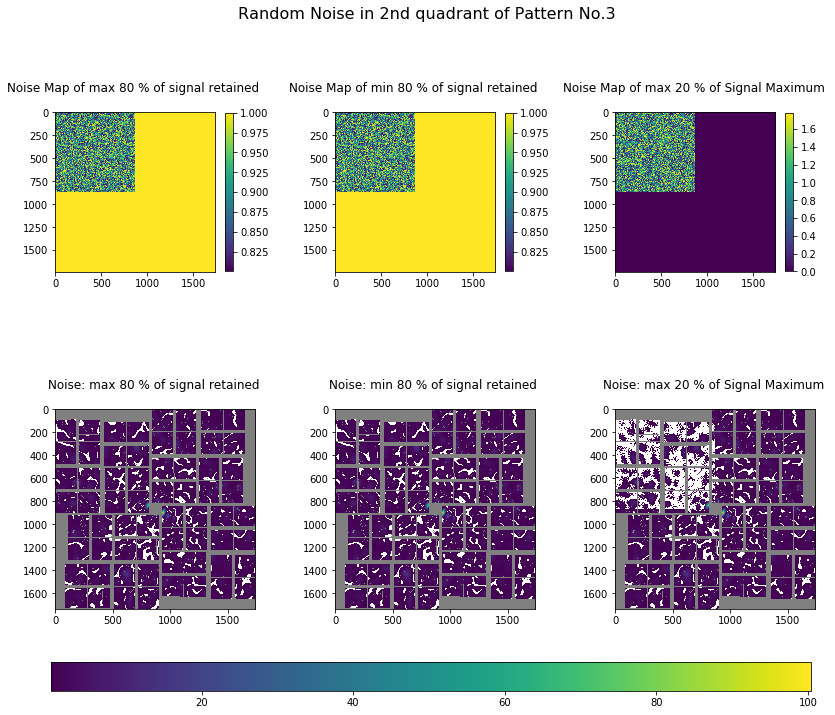

In [9]:
fig_noise = pypl.figure('noise', figsize=(12,10)) ## R1: Noise Maps; R2: Patterns ##
indx = 2 	## Which pattern to Plot ## 

vmax = max(np.amax(img_w_rand_noise_b1_mx), np.amax(img_w_rand_noise_b0)) ## max from rand-noise ##
print "max value in paterns: ", vmax

## PLOT of Max 80 % of the signal is retained (min of 20% noise): ##
pypl.subplot(231)
pypl.imshow(rand_b1_max[indx], cmap='viridis')
pypl.title('Noise Map of max %i %% of signal retained \n' %(inv_nlevel*100), fontsize=12)
pypl.colorbar( shrink=0.7) #pypl.colorbar(orientation="horizontal")
pypl.subplot(234)
img_b1_mx = np.ma.masked_where(mask_better == 0, img_w_rand_noise_b1_mx[indx])
pypl.imshow(img_b1_mx, vmin=0.1, vmax=vmax, cmap='viridis')
pypl.title('Noise: max %i %% of signal retained \n' %(inv_nlevel*100), fontsize=12)
cmap = cm.viridis
cmap.set_bad('grey',1.)
cmap.set_under('white',1.) 

## PLOT of Min 80 % of the signal is retained (max of 20% noise): ##
pypl.subplot(232)
pypl.imshow(rand_b1_min[indx], cmap='viridis')
pypl.title('Noise Map of min %i %% of signal retained \n' %(inv_nlevel*100), fontsize=12)
pypl.colorbar( shrink=0.7)
pypl.subplot(235)
img_b1_mn = np.ma.masked_where(mask_better == 0, img_w_rand_noise_b1_mn[indx])
pypl.imshow(img_b1_mn, vmin=0.1, vmax=vmax, cmap='viridis')
pypl.title('Noise: min %i %% of signal retained \n' %(inv_nlevel*100), fontsize=12)
cmap = cm.viridis
cmap.set_bad('grey',1.)
cmap.set_under('white',1.)


## PLOT of Noise prop to max signal of 1st Pattern : ##
pypl.subplot(233)
pypl.imshow(rand_1quad_b0[indx], cmap='viridis')
pypl.title('Noise Map of max %i %% of Signal Maximum \n' %(nlevel*100), fontsize=12)
pypl.colorbar( shrink=0.7)
pypl.subplot(236)
img_b0 = np.ma.masked_where(mask_better == 0, img_w_rand_noise_b0[indx])
pypl.imshow(img_b0, vmin=0.1, vmax=vmax, cmap='viridis')
pypl.title('Noise: max %i %% of Signal Maximum \n' %(nlevel*100), fontsize=12)
cmap = cm.viridis
cmap.set_bad('grey',1.)
cmap.set_under('white',1.)

cax = pypl.axes([0.065, 0.03, 0.88, 0.04])  ## left, bottom, width, hight ##
pypl.colorbar(cax=cax, orientation='horizontal')

pypl.suptitle("Random Noise in 2nd quadrant of Pattern No.%i" %(indx+1), fontsize=16)
pypl.subplots_adjust(wspace=0.4, hspace=0.4, left=0.07, right=0.95)
pic_name = '%s_%s_(%s-%s)_subplot_of_Random_Noise_1st-quad_Pattern-%i_(%iprc).%s'%(name,pdb,noisy,n_spread,(indx+1),nlevel*100,frmt)
#pypl.savefig(outdir + pic_name) ## Uncomment to Save the plot ##
print "Plot saved in %s \n as %s" %(outdir, pic_name)
pypl.show()

## Run CCA with LOKI:

### Importing Loki & Creating Storage Directory for CCA

In [10]:
if XCCA_Loki:
    from loki import RingData 	## RingData is a folder
    print "\n Data Analysis with LOKI.\n"
    from pylab import *	# load all Pylab & Numpy
    from loki.RingData import DiffCorr, InterpSimple
    print "\n Start Running 'Centre of Detector Loaded From File'.\n"
    
    m_b = mask_better
    img = Ip_w_mb
    pttrn = "Int"
    if add_noise:
        img = Ip_w_mb_w_Ns
        pttrn = "Int-add-noise-%iprc" %(nlevel*100)

    
    # ---- Generate a Storage File's Prefix: ---- 
    if random_noise_1quad:
        outdir = this_dir + '/random_noise_1quad_(%s_%s_%s)/' %(pdb,noisy,n_spread)
    else: outdir=this_dir
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    prefix = '%s_%s_' %(name,pdb)
    loki_folder = outdir + '/%s_%s_%s_with_LOKI/' %(name,run,pdb)
    if not os.path.exists(loki_folder):
        os.makedirs(loki_folder)
    out_fname = os.path.join( loki_folder, prefix)
    
    if N == 1: calc_AutoCorr = False	## Auto-correlation between diff. diffraction Patterns ##
    else:  calc_AutoCorr = True 		## only for N > 1 (ense no pattern to compare to) ##


 Data Analysis with LOKI.


 Start Running 'Centre of Detector Loaded From File'.



### Setting Parameters for CCA & Polar Calculasions:

In [11]:
    qmin_pix = rmin
    qmax_pix = rmax

    # ---- Single Pixel Resolution at Maximum q [1/A]: -----
    nphi = 180#360#180##90#
    print "\n nphi: ", nphi 	# = ,  20 (qmx=1135),  5(qmx=250)

    # ----- nphi (ANGULAR) Tic Parameters for choosen Pixel Resolution (for PLOTTING): ----
    nphi_bins = [nphi/8.0, nphi/4.0, nphi/2.0, 3*nphi/4.0, 7*nphi/8.0]	# 	# [nphi/4, nphi/2, 3*nphi/4]
    nphi_label = [r"$\pi/4$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$7\pi/4$" ]	# center of columen for full Period 2pi, # [ r'$\pi/2$', r'$\pi$', r'$3\pi/2$']

    # ---- Save g-Mapping (the q- values [qmin_pix,qmin_pix]): ----
    g_diff = qmax_pix -qmin_pix
    qrange_pix = np.arange( qmin_pix, qmax_pix)
    pix2invang = lambda qpix : sin(arctan(qpix*(ps*1E-6)/dtc_dist )/2)*4*pi/wl_A
    q_map = np.array( [ [ind, pix2invang(q)] for ind,q in enumerate( qrange_pix)])

    # ----- q (RADIAL) Tic Parameters for choosen Pixel Resolution (for PLOTTING): ----
    nq = q_map.shape[0]#q_step 	# Number of q radial polar bins
    q_bins = arange( 0, nq, nq/10 )	# 6 ticks arrange(start, stop, step-size)
    q_label = [ '%.3f'%(q_map[x,1]) for x in q_bins]

    # ---- Interpolater initiate : ----	# fs = fast-scan {x} cntr[0]; Define a polar image with dimensions: (qRmax-qRmin) x nphi
    Interp = RingData.InterpSimple( cntr[0], cntr[1], qmax_pix, qmin_pix, nphi, m_b.shape)

    # ---- Make a Polar Mask : ----
    polar_mask = Interp.nearest(m_b, dtype=bool).round() ## .round() returns a floating point number that is a rounded version of the specified number ##

    # ---- Generate Polar Image/Images (N Diffracton Patterns) : ----
    print "\n Starting to Calculate the Polar Images...\n"
    polar_imgs = np.array( [ polar_mask* Interp.nearest(img[i]) for i in range( N) ] )

    # ---- Normalize - with function: ----
    #polar_imgs_norm =norm_polar_img(polar_imgs, mask_val=0) # Function
    ## alt try: polar_imgs_norm = norm_data(polar_imgs)
    polar_imgs_norm = polar_imgs ## skip normalisation of simulated data ##


 nphi:  180

 Starting to Calculate the Polar Images...



### Compare Diffractions with Each Other (AUTO-Correlation) for N Patterns:

In [13]:
    #from Loki/Salca CXS tutorial
    if calc_AutoCorr:
        t_AC = time.time()
        print "\n Starting to Auto-Correlate the Polar Images...\n"
        # ---- Calculate the Difference in Intensities and store in a List: ----
        exposure_diffs = []
        exposure_diffs_cart =img[:-1]-img[1:]				# Intensity Patterns in Carteesian cor
        img_mean = np.array([ img[i].mean() for i in range(img.shape[0]) ]) ## Calculate the Mean of each pattern(shot) ##
        #exposure_diffs_cart= img[:-1]/img_mean[:-1]-img[1:]/img_mean[1:]  ## Normalize each pattern(shot) before subtraction ##
        del img_mean 	## Do not need the mean-values anymore ##
        exposure_diffs_cart = np.asarray(exposure_diffs_cart) 	# = (4, 1738, 1742)
        #exposure_diffs_cart = polarize(exposure_diffs_cart)  ## Polarize (if no fraction given => just 1s) ##
        exposure_diffs_cart = np.array( [ polar_mask* Interp.nearest(exposure_diffs_cart[i]) for i in range(exposure_diffs_cart.shape[0]) ] ) ## conv to polar of diff-data ##

        exposure_diffs_pol =polar_imgs_norm[:-1]-polar_imgs_norm[1:]	# Polar Imgs
        exposure_diffs_pol = np.asarray(exposure_diffs_pol) 	# = (4, 190, 5)

        # ---- Autocorrelation of each Pair: ----
        acorr = [RingData.DiffCorr( exposure_diffs_cart).autocorr(), 
                        RingData.DiffCorr( exposure_diffs_pol ).autocorr()]
        cor_mean = [RingData.DiffCorr( exposure_diffs_cart).autocorr().mean(0), 
                        RingData.DiffCorr( exposure_diffs_pol ).autocorr().mean(0)]

        # ---- Choose in which coordinate Systam to plot Autocorrelation in: ----				
        polar_diff = True#False
        if not polar_diff: 	# In Carteesian Coordinate System
            ind =0
            cord_sys = "Carteesian-diff"
        else:			# In Polar Coordinate System
            ind = 1
            cord_sys = "Polar-diff"
        cor_mean = np.asarray(cor_mean[ind]) # 0 = cart; 1 = polar

        t = time.time()-t_AC
        t_m =int(t)/60
        t_s=t-t_m*60
        print "AutoCorrelation Time: ", t_m, "min, ", t_s, " s \n"



 Starting to Auto-Correlate the Polar Images...

AutoCorrelation Time:  0 min,  0.127854824066  s 



### Plot the Auto-Correlations with the Random Noise in the 2nd quadrant: 


 Sub-plot saved as Figure_4_Diff-Auto-Corr_SUBPLOT_(qx-500_qi-300_nphi-180)_w_Mask_Polar-diff_Int-add-noise-20prc.eps 


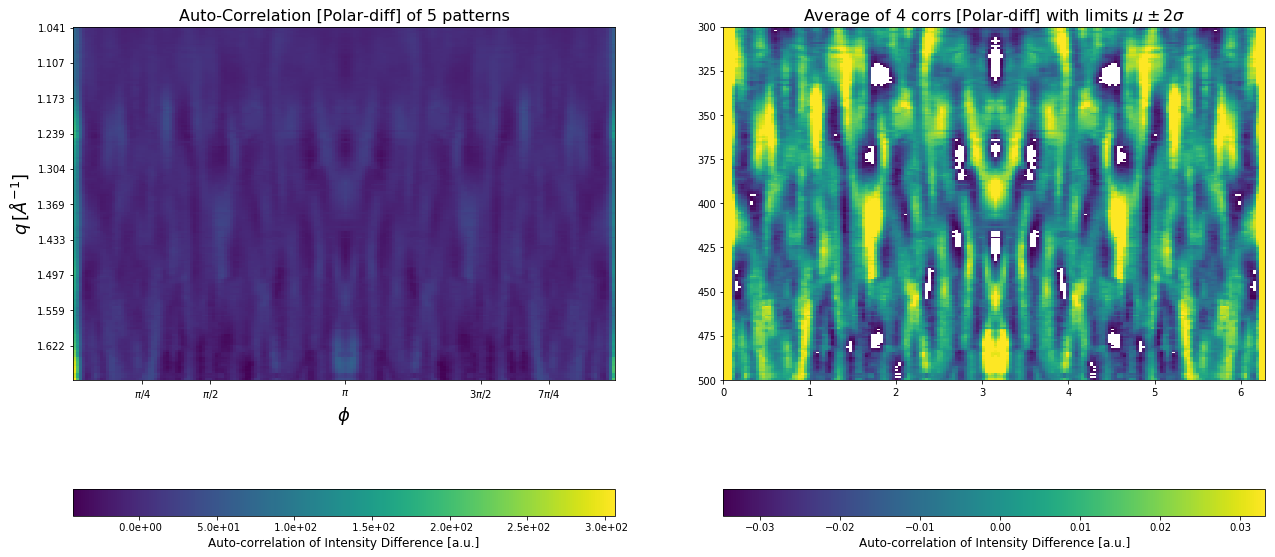

In [14]:
        ######################  PLOT Auto-Correlations [fig.4] : ################################################################## 
        pypl.figure(4, figsize=(18,10))
        cb_shrink, cb_padd = 1.0, 0.2
        pypl.subplot(121) #ALT. figure(figsize = (10, 10))
        im=imshow ( cor_mean, aspect='auto')
        cb = pypl.colorbar(im, orientation="horizontal", shrink=cb_shrink, pad= cb_padd, format = '%8.1e')	
        cb.set_label(r'Auto-correlation of Intensity Difference [a.u.]',  size=12) # normed intensity

        if polar_diff:
           # #---- Adjust the X-axis: ----  		## NEED Adj x tic for 5 tics
            xtic = nphi_bins 	#[nphi/4, nphi/2, 3*nphi/4]
            xlab = nphi_label 			# [ r'$\pi/2$', r'$\pi$', r'$3\pi/2$'] #nphi_bins or phi_bins_5
            pypl.xticks(xtic, xlab)

            # #---- Adjust the Y-axis: ----
            ytic = q_bins # arange( 0, nq, nq/10 )	# 6 ticks arrange(start, stop, step-size)
            ylab = q_label # [ '%.3f'%(q_map[x,1]) for x in ytic]
            pypl.yticks(ytic, ylab)

            # #---- Label xy-Axis: ----
            pypl.xlabel(r'$\phi$', fontsize = 18)
            pypl.ylabel(r'$q \, [\AA^{-1}]$', fontsize =18)

        pypl.title("Auto-Correlation [%s] of %i patterns" %(cord_sys,N),  fontsize=16)
        ############### [fig.4b]  Plot Sigma (Normed Auto-Correlation with +-2 std as limits)  ##############
        subplt_ave_corrs = True#False 		#### Plot the 2nd plot {adapted from in // GDrive/.../scripts/ave_corrs & 'plot_a_corr.py'} ####
        if subplt_ave_corrs:
            pypl.subplot(122) 	#### plot as in // GDrive/.../scripts/ave_corrs & 'plot_a_corr.py' #####
            corr = None
            for i in range(acorr[ind].shape[0]):		#acorr[ind].shape = (4, 190, 5)
                if corr is None:	corr = acorr[ind][i]
                else :	corr += acorr[ind][i]		# adter loop cr.shape = (190, 5)
            #print "\n corr shape: ", acorr[ind].shape, "\n & corr : ", corr.shape
            corrsum = np.zeros_like(corr)		
            corr_count =np.zeros(1)+(exposure_diffs_pol.shape[0]) #exposure_diffs_pol.shape[0] = N-1

            tot_corr_count = np.zeros(1)
            from mpi4py import MPI
            comm = MPI.COMM_WORLD
            comm.Reduce(corr,corrsum)
            comm.Reduce(corr_count, tot_corr_count)

            corrsum  =np.nan_to_num(corrsum)
            sig = corrsum/corrsum[:,0][:,None]/tot_corr_count[0] #if Polar: RuntimeWarning: invalid value encountered in divide ###### !ERROR !!!
            sig  =np.nan_to_num(sig)

            padC = 10#50 	# pad the edges of the correlation (remove self-correlation junk) /l.181
            m = sig[:,padC:-padC].mean() 	# MEAN
            s = sig[:,padC:-padC].std() 	# standard Deeviation
            vmin = m-2*s
            vmax = m+2*s
            
            ax = pypl.gca()
            if polar_diff:
                im = ax.imshow( sig,
                         extent=[0, 2*np.pi, qmax_pix, qmin_pix], 
                           vmin=vmin, vmax=vmax, aspect='auto')
            else : im =ax.imshow(sig, vmin=vmin, vmax=vmax, aspect='auto' )
            cb = pypl.colorbar(im, orientation="horizontal", shrink=cb_shrink, pad= cb_padd)	
            cb.set_label(r'Auto-correlation of Intensity Difference [a.u.]',  size=12) # normed intensity
            ax.set_title(r"Average of %d corrs [%s] with limits $\mu \pm 2\sigma$"%(tot_corr_count[0], cord_sys),  fontsize=16)
            ############### [fig.4b] End ###############
        #pypl.rcParams.update({'axes.labelsize': 14, 'xtick.labelsize':'small', 'ytick.labelsize':'small'})
        pypl.subplots_adjust(wspace=0.2, hspace=0.2, left=0.07, right=0.99)
        fig_name = "Figure_4_Diff-Auto-Corr_SUBPLOT_(qx-%i_qi-%i_nphi-%i)_w_Mask_%s_%s.%s" %(qmax_pix,qmin_pix, nphi,cord_sys,pttrn,frmt)
        #pypl.savefig( out_fname + fig_name)  ## Uncomment to Save the plot ##
        print "\n Sub-plot saved as %s " %fig_name
        pypl.show() 